**Indication pour tourner le code** : nous avons codé à partir de google colaboratory. Afin de récupérer les CSV, nous sommes passés par une fonction permettant de les récupérer depuis notre propre drive. 
Pour récupérer un CSV, il faut donc télécharger directement le fichier sur "Mydrive" puis run les lignes "#pathData='/content/drive/MyDrive/DataWVS.csv'", #world_map_datageo='/content/drive/MyDrive/World_map_geodata.json' , #shapefile = '/content/drive/MyDrive/World_map_2/World_map.shp' , #world_map_datageo=r'/content/drive/MyDrive/World_map_geodata.json' 
tout au long du code. 





---


### **INFLUENCE DE LA CONFIANCE SUR LA CONJONCTURE ECONOMIQUE**



---







**I. Un panorama des facteurs de la confiance**

Nous souhaitons tout d'abord analyser les facteurs de la confiance dans d'autres pays. 


En nous arrêtant sur la base de données de la World Values Survey, nous avons choisi d'étudier la confiance en économie. On s'est surtout alors intéressé à la confiance par le prisme de la confiance envers les banques ("Confidence : banks"), la confiance envers une institution internationale économique mondiale, le FMI ("Confidence : IMF), et finalement la confiance autour de la situation professionelle d'un individu. 
Néanmoins, nous avons aussi largement sélectionné toutes les données qui touchaient plus ou moins à la confiance en économie. 

Nous avons choisi d'étudier les données depuis 2010, pour s'approcher au mieux des problématiques actuelles. 



On importe tout d'abord les modules. 

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import linregress
import matplotlib.pyplot as plt
from math import log

import urllib
import bs4
import collections

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

import seaborn as sns
import os
import json

!pip install geopandas

import geopandas as gpd


     |████████████████████████████████| 1.0 MB 4.7 MB/s 
     |████████████████████████████████| 6.3 MB 42.8 MB/s 
     |████████████████████████████████| 15.4 MB 53.3 MB/s 


On récupère ensuite la base CSV et on affiche l'en-tête de la base. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#pathData='/content/drive/MyDrive/DataWVS.csv'
pathData='/content/drive/MyDrive/Projet Python économiste/BDD/DataWVS.csv'
dfWVS=pd.read_csv(pathData)

dfWVS.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (26,632,635,648,678,679) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,studyno,version,doi,stdyno_w,versn_w,S001,S002,S002VS,S003,COW_NUM,COW_ALPHA,S004,S006,S007,S007_01,S008,S009,MODE,S010,S011A,S011B,S012,S013,S013B,S016,S016a,S017,S018,S019,PWGHT,S020,S021,S022,S023,S024,S025,A001,A002,A003,...,X053,X054,X055,Y001,Y002,Y003,Y010,Y011,Y011A,Y011B,Y011C,Y012,Y012A,Y012B,Y012C,Y013,Y013A,Y013B,Y013C,Y014,Y014A,Y014B,Y014C,Y020,Y021,Y021A,Y021B,Y021C,Y022,Y022A,Y022B,Y022C,Y023,Y023A,Y023B,Y023C,Y024,Y024A,Y024B,Y024C
0,1,4001,v2.0 (2021-07-07),doi:10.14281/18241.15,346,WVS1,2,1,1,32,160,ARG,NaN,1,320120001,320120001.0,NaN,AR,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926626,0.995025,1.383024,1.0,1984,3201211984,NaN,NaN,321,321984,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,-2.0,0.232690,0.32476,0.0,0.33,NaN,0.166,NaN,0.0,0.166667,0.000000,0.0,0.0,0.0,0.440000,0.66,0.33,0.33,0.141896,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.136,0.0,NaN,NaN
1,2,4001,v2.0 (2021-07-07),doi:10.14281/18241.15,346,WVS1,2,1,1,32,160,ARG,NaN,2,320120002,320120002.0,NaN,AR,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926626,0.995025,1.383024,1.0,1984,3201211984,NaN,NaN,321,321984,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,-1.0,0.407357,0.32476,0.0,0.33,NaN,0.088,NaN,0.0,0.000000,0.666667,1.0,1.0,0.0,0.550000,0.66,0.66,0.33,0.230563,0.333333,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.136,0.0,NaN,NaN
2,3,4001,v2.0 (2021-07-07),doi:10.14281/18241.15,346,WVS1,2,1,1,32,160,ARG,NaN,3,320120003,320120003.0,NaN,AR,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926626,0.995025,1.383024,1.0,1984,3201211984,NaN,NaN,321,321984,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,0.0,0.336357,0.32476,0.0,0.33,NaN,0.244,NaN,0.0,0.333333,0.666667,1.0,1.0,0.0,0.110000,0.33,0.00,0.00,0.420896,0.666667,0.0,1.0,1.0,NaN,NaN,NaN,NaN,0.333333,0.111111,0.333333,0.555556,0.136,0.0,NaN,NaN
3,4,4001,v2.0 (2021-07-07),doi:10.14281/18241.15,346,WVS1,2,1,1,32,160,ARG,NaN,4,320120004,320120004.0,NaN,AR,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.352874,0.995025,2.019215,1.0,1984,3201211984,NaN,NaN,321,321984,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,1.0,0.764118,0.62902,0.5,0.66,NaN,NaN,NaN,1.0,NaN,1.000000,1.0,1.0,1.0,0.663333,1.00,0.33,0.66,0.664994,0.666667,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.518519,0.333333,0.555556,0.666667,0.792,1.0,NaN,NaN
4,5,4001,v2.0 (2021-07-07),doi:10.14281/18241.15,346,WVS1,2,1,1,32,160,ARG,NaN,5,320120005,320120005.0,NaN,AR,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926626,0.995025,1.383024,1.0,1984,3201211984,NaN,NaN,321,321984,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,0.583065,0.50626,0.5,0.33,NaN,0.166,NaN,0.0,0.166667,1.000000,1.0,1.0,1.0,0.660000,0.66,0.66,0.66,0.420896,0.666667,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.333333,0.444444,0.222222,0.333333,0.136,0.0,NaN,NaN


On supprime les colonnes inutiles (celles ne décrivant aucune donnée), ou les colonnes qui ont des valeurs floats et str à la fois. dfWVS sera utilisé par la suite pour évaluer la pertinence de notre choix de variables pertinentes.


In [ ]:
dfWVS=dfWVS.drop(['studyno','version',	'doi',	'stdyno_w',	'versn_w',
                  'S004', 'V001A_01', 'V002A_01','X002_02B','X048H_N1','X048I_N2'], axis=1)
dfWVS

,Unnamed: 0,S001,S002,S002VS,S003,COW_NUM,COW_ALPHA,S006,S007,S007_01,S008,S009,MODE,S010,S011A,S011B,S012,S013,S013B,S016,S016a,S017,S018,S019,PWGHT,S020,S021,S022,S023,S024,S025,A001,A002,A003,A004,A005,A006,A007,A008,A009,...,X053,X054,X055,Y001,Y002,Y003,Y010,Y011,Y011A,Y011B,Y011C,Y012,Y012A,Y012B,Y012C,Y013,Y013A,Y013B,Y013C,Y014,Y014A,Y014B,Y014C,Y020,Y021,Y021A,Y021B,Y021C,Y022,Y022A,Y022B,Y022C,Y023,Y023A,Y023B,Y023C,Y024,Y024A,Y024B,Y024C
0,1,2,1,1,32,160,ARG,1,320120001,3.201200e+08,NaN,AR,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926626,0.995025,1.383024,1.000000,1984,3201211984,NaN,NaN,321,321984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,...,NaN,NaN,NaN,NaN,1.0,-2.0,0.232690,0.324760,0.0,0.33,NaN,0.166000,NaN,0.0,0.166667,0.000000,0.0,0.0,0.0,0.440000,0.66,0.33,0.33,0.141896,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.136,0.00,NaN,NaN
1,2,2,1,1,32,160,ARG,2,320120002,3.201200e+08,NaN,AR,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926626,0.995025,1.383024,1.000000,1984,3201211984,NaN,NaN,321,321984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,1.0,-1.0,0.407357,0.324760,0.0,0.33,NaN,0.088000,NaN,0.0,0.000000,0.666667,1.0,1.0,0.0,0.550000,0.66,0.66,0.33,0.230563,0.333333,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.136,0.00,NaN,NaN
2,3,2,1,1,32,160,ARG,3,320120003,3.201200e+08,NaN,AR,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926626,0.995025,1.383024,1.000000,1984,3201211984,NaN,NaN,321,321984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,...,NaN,NaN,NaN,NaN,1.0,0.0,0.336357,0.324760,0.0,0.33,NaN,0.244000,NaN,0.0,0.333333,0.666667,1.0,1.0,0.0,0.110000,0.33,0.00,0.00,0.420896,0.666667,0.0,1.0,1.0,NaN,NaN,NaN,NaN,0.333333,0.111111,0.333333,0.555556,0.136,0.00,NaN,NaN
3,4,2,1,1,32,160,ARG,4,320120004,3.201200e+08,NaN,AR,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.352874,0.995025,2.019215,1.000000,1984,3201211984,NaN,NaN,321,321984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,...,NaN,NaN,NaN,NaN,3.0,1.0,0.764118,0.629020,0.5,0.66,NaN,NaN,NaN,1.0,NaN,1.000000,1.0,1.0,1.0,0.663333,1.00,0.33,0.66,0.664994,0.666667,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.518519,0.333333,0.555556,0.666667,0.792,1.00,NaN,NaN
4,5,2,1,1,32,160,ARG,5,320120005,3.201200e+08,NaN,AR,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926626,0.995025,1.383024,1.000000,1984,3201211984,NaN,NaN,321,321984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,...,NaN,NaN,NaN,NaN,1.0,1.0,0.583065,0.506260,0.5,0.33,NaN,0.166000,NaN,0.0,0.166667,1.000000,1.0,1.0,1.0,0.660000,0.66,0.66,0.66,0.420896,0.666667,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.333333,0.444444,0.222222,0.333333,0.136,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422145,422146,2,7,7,716,552,ZIM,1211,7160721211,7.160721e+09,50.0,ZW,1,77.0,10.51,12.08,20200322.0,1.0,1.0,128.0,en,1.000000,0.823045,1.234568,0.660905,2020,71607212020,202002.0,202003.0,7167,7162020,1.0,3.0,1.0,1.0,1.0,2.0,NaN,2.0,1.0,...,NaN,NaN,NaN,2.0,2.0,-1.0,0.291389,0.000000,0.0,0.00,0.00,0.165556,0.33,0.0,0.166667,1.000000,1.0,1.0,1.0,0.000000,0.00,0.00,0.00,0.366667,0.666667,0.0,1.0,1.0,0.220000,0.00,0.00,0.66,0.000000,0.000000,0.000000,0.000000,0.580,0.66,0.5,0.580
422146,422147,2,7,7,716,552,ZIM,1212,7160721212,7.160721e+09,50.0,ZW,1,80.0,12.25,13.45,20200322.0,1.0,1.0,128.0,en,1.000000,0.823045,1.234568,0.660905,2020,71607212020,202002.0,202003.0,7167,7162020,1.0,1.0,2.0,1.0,1.0,1.0,NaN,2.0,1.0,...,NaN,NaN,NaN,3.0,3.0,-1.0,0.276667,0.333333,0.0,1.00,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.773333,0.66,1.00,0.66,0.439815,0.333333,0.0,0.0,1.0,0.666667,1.00,0.00,1.00,0.259259,0.000000,0.000000,0.777778,0.500,1.00,0.0,0.500
422147,422148,2,7,7,716,552,ZIM,1213,7160721213,7.160721e+09,60.0,ZW,1,59.0,14.23,15.22,20200322.0,1.0,1.0,405.0,sn,1.000000,0.823045,1.234568

Récupération d'une batterie de colonnes d'apparence pertinente pour notre étude. Il faut les renommer ensuite, car les variables dans le CSV initial ont des noms inintelligibles.

On sélectionne donc, comme annoncé en introduction les données relatives à la confiance en économie. 
Finalement, on ne prend les données qu'à partir de 2010. 

In [ ]:
#Sélection des colonnes qui nous intéressent 
mycolumns = ['COW_ALPHA','S020','A001','A002','A003','A004',
             'A005','A006','A007','A008','A009','A062','A064','A065','A066','A067','A068', 
             'A069','A071','A072','A073','A075','A076','A077','A080','A080_01','A080_02', 
             'A101','A102','A103','A165','A168','A169','A170','C006','E014','E015','E016', 
             'E017','E018','E019','E020','E022','E023','E033','E034','E037','E057','E069_04', 
             'E069_05','E069_11','E069_13','E069_41','E069_45','E110','E111_01','E113','E120','E142', 
             'E150','G007_01','G007_18_B','G007_33_B','G007_34_B','H006_01',
             'X001','X003','X045','X046','X047_WVS'] 

df=dfWVS[mycolumns]


#On renomme les colonnes pour avoir des noms plus explicites 
df.columns=['Countries','Year of survey','Important in life: Family','Important in life: Friends','Important in life: Leisure time',
               'Important in life: Politics','Important in life: Work','Important in life: Religion','Important in life: Service to others',
               'Feeling of happiness','State of health (subjective)','How often discusses political matters with friends',
               'Member: belong to social welfare service for elderly','Member: belong to religious organization',
               'Member: belong to education, arts, music or cultural activities','Member: belong to labour unions',
               'Member: belong to political parties','Member: belong to local political actions',
               'Member: belong to conservation movement (ecology)','Member: belong to professional associations',
               'Member: belong to youth work','Member: belong to women\'s groups', 'Member: belong to peace movement',
               'Member: belong to organization concerned with health','Member: belong to none','Member: belong to humanitarian/charitable organization',
               'Member: belong to self-help group, mutual aid group','Active/Inactive membership of labour unions',
               'Active/Inactive membership of political party','Active/Inactive membership of environmental organization',
               'Distrust in others','Most people try to take advantage of you','Good human relationships',
               'Satisfaction with your life','Satisfaction with financial situation of household',
               'Future changes: less emphasis on money and material possession','Future changes: less importance placed on work',
               'Future changes: more emphasis on technology','Future changes: more emphasis on individual',
               'Future changes: greater respect for authority','Future changes: more emphasis on family life',
               'Future changes: simple and more natural lifestyle', 'Opinion about scientific advances','Interest in politics',
               'Self positioning in political scale','Basic kinds of attitudes concerning society',
               'Government responsibility','The economic system needs fundamental changes','Confidence: The press',
               'Confidence: labour unions','Confidence: The government','Confidence: Major companies','Confidence: Banks',
               'Confidence: IMF','Satisfaction with the way democracy develops','Satisfaction with the political system',
               'Rate political system in 10 years','In democracy, the economic system runs badly','Country cannot solve employment problems by itself',
               'How often follows politics in the news','Trust: other people in country','Trust: your neighborhood',
               'Trust: people you know personally','Trust: people you meet for the first time',
               'Job-related worries','Sex','Age','Social class','Socio-economic status','Scale of incomes']

#on ne choisit que les années qui nous intéressent (au delà de 2010)
df=df[df['Year of survey']>=2010]

On affiche ensuite le nombre d'observations que l'on aura à traiter 

In [ ]:
np.shape(df)

(166462, 70)

On se retrouve donc finalement avec une base de données de plus de 166000 observations, mettant en jeu 70 variables.

# *A. Nettoyage de la base de données pour former les cartes à partir des variables 'Confidence: Banks', 'Job-related worries', et 'Most people can be trusted'*


Nous décidons tout d'abord de former des cartes choroplèthes pour mettre en valeur les scores de confiance au niveau planétaire. 

'Confidence : Banks' s'arrête sur la confiance envers les banques. 

'Job-related worries' est davantage personnelle, autour du statut professionnel. 

Finalement 'most people can be trusted' est une variable intéressante à comparer. Il s'agit en effet d'une variable déclarative sur le taux de confiance dans une population. Elle est moins axée sur l'économie, mais nous permet d'approcher la confiance générale. 

On crée donc une nouvelle base de donnée "df_for_map" ne prenant en compte que ces 3 données en colonnes. 
Pour chaque pays étudié, on réalise la moyenne de toutes ces données sur les différentes années prises en compte (au delà de 2010). 
On supprime également les pays ayant des valeurs non renseignées. 

In [ ]:
df_for_map=pd.DataFrame(columns=['Confidence: Banks','Job-related worries','Distrust in others']) #on crée un nouveau tableau ayant en colonne les variables étudiées. 
ListCountries=df['Countries'].unique() #on prend en compte les pays offerts dans la base de données d'origine 

for country in range(len(ListCountries)): #on réalise la moyenne pour chaque pays de ces 3 données, depuis 2010. 
    Row=[]
    Trust_in_Banks_Mean=df[df['Countries']==ListCountries[country]]['Confidence: Banks'].mean()
    Row.append(Trust_in_Banks_Mean)
    
    Job_Related_Worries_Mean=df[df['Countries']==ListCountries[country]]['Job-related worries'].mean()
    Row.append(Job_Related_Worries_Mean)
    
    Trust_in_People_Mean=df[df['Countries']==ListCountries[country]]['Distrust in others'].mean()
    Row.append(Trust_in_People_Mean)
    
    df_for_map.loc[country]=Row
    df_for_map.rename(index={country: ListCountries[country]}, inplace=True)
    df_for_map=df_for_map.dropna()

#on multiplie finalement par 25 et par 50 les valeurs afin de les échelonner de 25 à 100. 
df_for_map['Confidence: Banks']*=25
df_for_map['Job-related worries']*=25
df_for_map['Distrust in others']*=50

df_for_map=df_for_map.drop(['ROK','BNG','DRV','NTH'],0)
#on supprime les pays sans valeur 

In [ ]:
df_for_map.head()

,Confidence: Banks,Job-related worries,Distrust in others
ALG,65.559441,45.432264,91.035683
ARG,73.564533,63.874810,89.014374
ARM,60.014549,36.793785,94.930876
AUL,68.858292,70.593382,72.897483
AZE,59.031936,50.176234,91.675231


Pour avoir des noms plus explicites, il convient de renommer la colonne des indices avec les noms des pays. Il est nécessaire de faire cette étape pour pouvoir construire la carte, du fait qu'il faut superposer des couches de même nom pour colorer un pays sur la carte et le fichier World_map_geodata.json prend en indice les noms explicites, en anglais, de chaque pays.

In [ ]:
world_map_datageo=r'/content/drive/MyDrive/Projet Python économiste/BDD/World_map_geodata.json'
#world_map_datageo='/content/drive/MyDrive/World_map_geodata.json'

with open(world_map_datageo) as json_data: #on ouvre ce fichier comme un fichier json, cad un fichier permettant l'échange d'informations. 
    data_dict = json.load(json_data) #on stocke les données de ce fichier JSON dans un dictionnaire Python. 

data_str = json.dumps(data_dict)# on stocke les données dans une chaîne de caractères data_str en passant par la fonction dumps. 

data_dict_02 = json.loads(data_str) #on remet ces données dans un dictionnaire 

denominations_json = []
for index in range(len(data_dict_02['features'])): 
    denominations_json.append(data_dict_02['features'][index]['properties']['name'])
#on accorde alors les noms des pays de cette bibliothèque avec ceux de notre base de données


dataframe_names = df_for_map.index.tolist() 
#on crée la liste à partir des différents noms à remplacer 

geojson_names = ['Argentina', 'Australia','Japan', 'Mexico', 'South Africa','Belarus','Brazil','Chile','China',
                 'India','Nigeria','Poland','Russia','Spain','Turkey','Armenia','Azerbaijan', 'Colombia',
                 'Estonia','Georgia','Germany', 'New Zealand', 'Macao', 'Pakistan','Peru', 'Philippines', 'Puerto Rico', 'Romania',
                 'Serbia','El Salvador','Sweden','Taïwan', 'Ukraine','Uruguay','United States','Algeria','Canada','Egypt',
                 'Indonesia','Iran','Iraq','Jordania','Kyrgyzstan','Morocco','Singapore','Zimbabwe','Andorra',
                 'Cyprus','Ethiopia','Ghana','Guatemala','Hong Kong','Malaysia','Rwanda','Thailand','Trinidad and Tobago',
                 'Ecuador','Haiti','Kazakhstan','Kuwait','Lebanon','Libya','Palestine','Qatar','Tunisia','Uzbekistan',
                 'Yemen','Bolivia','Greece','Myanmar','Nicaragua','Tajikistan']
#on reprend les noms de la bibliothèque que l'on souhaite accorder avec les accronymes de notre premiere base de donnée 

df_for_map=df_for_map.rename(dict(zip(dataframe_names, geojson_names)))
#ON applique ces nouveaux noms à notre base. 

#On réordonne alphabétiquement le dataframe
df_for_map['labels'] = df_for_map.index.str.lower()
df_for_map = df_for_map.sort_values('labels').drop('labels', axis=1)

On affiche rapidement la taille de chaque série de variables pour vérifier combien de pays vont apparaître coloriés sur la carte. 

In [ ]:
for i in df_for_map.columns: #pour chaque valeur que l'on souhaite observer dans notre nouvelle base (les variables sont mises en colonne) 
    dfi=df_for_map[i].dropna() #on analyse les ligne grâce à dfi 
    print('{} '.format(i),np.shape(dfi)) #on affiche le format pour avoir le nombre de pays pour chaque variable considérée 
    

Confidence: Banks  (72,)
Job-related worries  (72,)
Distrust in others  (72,)


# *B. Construction des cartes*

In [ ]:
shapefile = '/content/drive/MyDrive/Projet Python économiste/BDD/World_map_2/World_map.shp'
#shapefile = '/content/drive/MyDrive/World_map_2/World_map.shp'
#On lit shapefile en utilisant Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']] #On lit shapefile grâce à geopandas et on renomme shadefile gdf 



#On renomme les colonnes 
gdf.columns = ['Country', 'country_code', 'geometry']

#on renomme certains pays pour que les deux bases, gdf et df_for_map puissent être mergées. 
gdf['Country'][1]='Tanzania'
gdf['Country'][4]='United States'
gdf['Country'][17]='Dominican Rep.'
gdf['Country'][170]='Bosnia and Herz.'

#On retire la ligne de l'Antartique 
gdf = gdf.drop(gdf.index[159])

#on associe les deux bases sur une même base 
merged = gdf.merge(df_for_map, left_on = 'Country', right_on = df_for_map.index, how= 'left')

#on stocke cette nouvelle base dans json
merged_json = json.loads(merged.to_json())

#On l'a converti à string comme un objet
json_data = json.dumps(merged_json)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


On crée tout d'abord la carte pour la valeur "Confiance dans les institutions bancaires" cad "Confidence : banks"

In [ ]:
# GeoJSON contient des données pour le traçage 
geosource = GeoJSONDataSource(geojson = json_data)

#On définit les palettes de couleur 
palette = brewer['PuOr'][10]

#On inverse pour que le bleu foncé corresponde à la valeur la plus élevée 
palette = palette[::-1]

#LinearColorMapper permet de ranger les nombres dans un ordre, selon une séquence de couleurs. 
color_mapper = LinearColorMapper(palette = palette, low = 35, high = 85)

#On définit les étiquettes de graduation pour la barre colorée
tick_labels = {'35':'35', '40':'40','45':'45', '50':'50', '55':'55',               
               '60':'60', '65':'65', '70':'70','75':'75', '80':'80','85':'85'}

#On crée la barre colorée selon ces graduations 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal',
                     major_label_overrides = tick_labels)

#On crée la figure 
p = figure(title = 'Confiance dans les institutions bancaires', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

p.patches('xs','ys', source = geosource,fill_color = {'field' :'Confidence: Banks', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Disposition de la figure 
p.add_layout(color_bar, 'below')
#On montre la figure grace au notebook
output_notebook()
#Display figure.
show(p)


On réalise la même carte pour la "défiance dans le marché du travail" 

In [ ]:
palette2 = brewer['RdBu'][11]

color_mapper = LinearColorMapper(palette = palette2, low = 25, high = 80)


tick_labels = {'25':'25','30':'30','35':'35','40':'40','45':'45', '50':'50', '55':'55',               
               '60':'60', '65':'65', '70':'70','75':'75', '80':'80'}

 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal',
                     major_label_overrides = tick_labels)

p = figure(title = 'Défiance dans le marché du travail', plot_height = 600 , plot_width = 950,
           toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

p.patches('xs','ys', source = geosource,fill_color = {'field' :'Job-related worries', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)


p.add_layout(color_bar, 'below')

output_notebook()

show(p)

Finalement, on réalise la même carte pour "propension à la défiance envers les autres", qui pourrait montrer un manque de confiance envers la société.

Néanmoins, cette carte ne sera pas utilisée, car nous pensions voir dans "propension à la défiance envers les autres" la synthèse des 3 variables suivantes, que nous étudions ci-après dans le document: "Trust, neighborhood", "trust : people you know personnaly", "Trust : people you meet for the first time", cad la confiance envers ses voisins, envers son entourage, envers des inconnus. 

Or ces 3 variables ont des résultats finalement opposés. 
On ne peut donc les regrouper selon une seule variable "propension à la défiance envers les autres". 

In [ ]:
palette3 = brewer['RdYlGn'][7]

color_mapper = LinearColorMapper(palette = palette3, low = 65, high = 100)


tick_labels = {'65':'65', '70':'70','75':'75', '80':'80',
               '85':'85', '90':'90','95':'95', '100':'100'}


color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal',
                     major_label_overrides = tick_labels)


p = figure(title = 'Propension à la défiance envers les autres', plot_height = 600 , plot_width = 950,
           toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None


p.patches('xs','ys', source = geosource,fill_color = {'field' :'Distrust in others', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)


p.add_layout(color_bar, 'below')

output_notebook()

show(p)


# *C. Repérage de données pertinentes à notre étude*

##Définition d'une fonction qui renvoie l'indice de corrélation de Spearman entre deux séries

Nous privilégions l'indice de corrélation de Spearman à celui plus traditionnel de Pearson car ce dernier prend davantage en compte les valeurs au sein des séries, tandis que celui de Spearman évalue le rang que chaque donnée occupe dans la série. Du fait que les réponses aux enquêtes sont des valeurs discrètes, l'indice de Spearman est plus adapté.

In [ ]:
#on crée une nouvelle fonction get_R2 qui permet de calculer l'indice de Spearman entre deux séries. 

def get_R2(serie1,serie2): 
    return(stats.spearmanr(serie1,serie2)[0])
    #le calcul de l'indice de Spearman se fait donc en fonction du rang que chaque donnée occupe dans la série.

On sélectionne plusieurs variables pertinentes à notre étude qu'on met dans une liste nommée ListGivenData. On s'intéresse ici à évaluer les coefficients de corrélation (de Spearman donc) de chacune des variables par rapport aux variables d'intérêt de ListGivenData.

En sortie, on renvoie un dataframe dont les colonnes sont les variables d'intérêt dans notre problématique, et les lignes sont des variables de la base de données dont on cherche à savoir si elles expliquent efficacement ou non les variables d'intérêt.

In [ ]:
ListGivenData=['Confidence: Banks','Confidence: IMF','Job-related worries'] 

In [ ]:
compt=0 #on initialise le compte à 0 

df_corr=pd.DataFrame(columns=ListGivenData) #on crée un nouveau dataframe à partir de la liste de nos valeurs. 

for variableIndex in range(1,len(df.columns)): #On parcourt les colonnes du dataframe de travail, en récupérant son indice
    variableName=df.columns[variableIndex] #On récupère le nom de la variable 
    Row=[] #On crée une ligne vide 
    for givenDataName in ListGivenData: #On parcourt la liste des variables d'études
        if givenDataName==variableName: #si les noms des variables sont identiques, alors on continue la boucle 
            continue
        givenDataIndex=df.columns.get_loc(givenDataName) #On récupère l'indice de la variable d'intérêt

        #On extrait un sous-dataframe qui contient les deux colonnes à partir desquelles l'on va calculer

        dfv=df.iloc[:,[variableIndex,givenDataIndex]]
        dfv=dfv.dropna() #On retire les valeurs manquantes, en prenant le risque que le dataframe soit finalement vide
        s=np.shape(dfv)
        if s[0]==0: #Test pour savoir si le dataframe est vide ou non. S'il l'est, on attribue la valeur NaN à la liste Row
            Row.append(np.nan)
        else:
            R2=get_R2(dfv[variableName],dfv[givenDataName]) #S'il n'est pas vide, on calcule le coefficient de corrélation associé aux deux colonnes de dfv
            Row.append(R2)
    
#On teste bien que toutes les valeurs de la ligne ont été renseignées, de sorte que les longueurs de la ligne
#et de la liste des variables d'intérêt coïncident

    if len(Row)!=len(ListGivenData):
        continue

#On ajoute la ligne au dataframe df_corr, et ensuite on renomme l'index de la ligne
    df_corr.loc[compt]=Row
    df_corr.rename(index={compt: variableName}, inplace=True)


On construit alors une variable Score qui est simplement la somme des valeurs absolues des coefficients de Spearman calculés juste avant. Ceci permet de faire un classement des variables les plus pertinentes à la prédiction des trois variables d'intérêt à la fois, et de ne pas devoir sélectionner arbitrairement l'une des trois pour classer.

In [ ]:
df_corr['Score']=abs(df_corr['Confidence: Banks'])+abs(df_corr['Confidence: IMF'])+abs(df_corr['Job-related worries'])
df_corr=df_corr.sort_values(by='Score', ascending=False)
df_corr.head(10)

,Confidence: Banks,Confidence: IMF,Job-related worries,Score
Confidence: Major companies,0.548557,0.436764,0.020473,1.005795
Confidence: The government,0.389806,0.409455,-0.037683,0.836944
Confidence: labour unions,0.339343,0.383746,0.003354,0.726443
Confidence: The press,0.336338,0.364669,-0.002995,0.704002
Satisfaction with the political system,-0.220327,-0.217993,0.071209,0.509529
Satisfaction with financial situation of household,-0.110929,-0.121840,0.134101,0.366871
Trust: your neighborhood,0.140158,0.149360,-0.071709,0.361227
Important in life: Work,0.076141,0.019184,0.261621,0.356946
Trust: people you meet for the first time,0.061460,0.156918,-0.119215,0.337593
Trust: people you know personally,0.110672,0.121595,-0.095370,0.327637


On a ainsi accès, grâce à cette méthode de classement simple, aux dix variables les plus efficaces dans la prédiction de la confiance accordée aux banques, au FMI et à la défiance dans le marché du travail.

Lecture: La variable d'intérêt "Confidence: Banks" peut s'expliquer à 54,9% par la variable "Confidence: Major companies". Ainsi, on prédit qu'une personne qui accorde sa confiance aux grandes entreprises aura tendance à faire de même pour les banques.

Toutefois, ces calculs ont été réalisés à partir des variables préalablement sélectionnées comme pertinentes à nos yeux (on a travaillé sur df et non pas directement sur dfWVS, trop volumineuse). Il convient donc, à présent de comparer notre sélection manuelle, à ces mêmes calculs mais pour toute la base, pour bien s'assurer de ne pas avoir oublié de composantes essentielles dans notre analyse.

Pour cela, on reproduit le même code, à quelques modifications près, pour dfWVS.

In [ ]:
compt=0
#print(ListGivenData)
dfWVS=dfWVS[dfWVS['S020']>=2010]
df_corr2=pd.DataFrame(columns=['E069_41', 'E069_45','H006_01'])

for variableIndex in range(1,len(dfWVS.columns)): #On parcourt les colonnes du dataframe de travail, en récupérant son indice
    variableName=dfWVS.columns[variableIndex] #On récupère le nom de la variable 
    Row=[]
    for givenDataName in df_corr2.columns: #On parcourt la liste des variables d'études
        if givenDataName==variableName:
          continue
        givenDataIndex=dfWVS.columns.get_loc(givenDataName) 
        dfv=dfWVS.iloc[:,[variableIndex,givenDataIndex]]
        dfv=dfv.dropna()
        dfv=dfv.reset_index(drop=True)
        s=np.shape(dfv)
        if s[0]==0:
          Row.append(np.nan)
        #elif type(dfv[variableName][0]) not in [float, int]:
          #continue
        else:
          R2=get_R2(dfv[variableName],dfv[givenDataName])
          Row.append(R2)
    
    if len(Row)!=len(df_corr2.columns):
      continue
    df_corr2.loc[compt]=Row
    df_corr2.rename(index={compt: variableName}, inplace=True)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: 

In [ ]:
df_corr2['Score']=abs(df_corr2['E069_41'])+abs(df_corr2['E069_45'])+abs(df_corr2['H006_01'])
df_corr2=df_corr2.sort_values(by='Score', ascending=False)
df_corr2.head(60)

,E069_41,E069_45,H006_01,Score
E069_59,0.409174,0.620795,-0.047480,1.077449
E069_30,0.405164,0.611486,0.017516,1.034166
E069_19,0.360709,0.635944,-0.027922,1.024575
E069_20,0.367315,0.634391,-0.007998,1.009704
E069_43,0.427564,0.558644,-0.021277,1.007485
E069_13,0.548557,0.436764,0.020473,1.005795
E069_55,0.435721,0.512824,-0.029428,0.977974
E069_18A,0.379573,0.575632,0.018222,0.973427
E069_27,0.319909,0.523985,0.116174,0.960068
E069_21,0.328676,0.571812,-0.057123,0.957611


On aboutit alors à un tableau similaire, mais avec des noms inintelligibles. Les variables en colonne sont les mêmes que ci-avant, dans le même ordre, et elles ont simplement été remplacés par leur code.

On remarque que sur les 35 premières variables, 30 sont de la forme 'E069_xx'. Ce code correspond à toutes les variables de la forme 'Confidence: xxxxx'. Par exemple, 'Confidence: Banks' et 'Confidence: IMF' ont pour code 'E069_41'	et 'E069_45' respectivement. On retrouve par exemple, en 6ème position, la confiance dans les grandes entreprises ('E069_13'). Le détail est dipsonible dans le rapport *EVS 1981 - 2008 Variable Report
Longitudinal data Files*.

Apparaît donc nettement un profil que l'on pourrait qualifier de profil confiant manichéen: soit une personne fait confiance à l'ensemble des institutions (gouvernement, presse, syndicats, grandes entreprises, mais également ONG environnementales, les universités, l'OTAN, la télévision ou encore la présidence), soit à aucune.



---


**II. Régression linéaire entre les pays selon le type de confiance** 



---







Après avoir réalisé un panorama global de la confiance en France, il convient désormais d'étudier les effets de la confiance sur l'économie.

On s'attarde donc à construire des régressions linéaires entre les pays, pour évaluer les déterminants de la confiance dans l'économie, selon certains paramètres (PIB nominal, PIB par tête).

On reprend alors de notre dataframe les variables "Confidence : banks", "Confidence : IMF" et "Job-related worries". 

Dans notre étude, nous tenons compte également de la situation géographique et politique du pays, grâce à une variable RegionInst (renvoyant le continent du pays concerné), et grâce à la variable PoliticalRegimeInt (indiquant si l'on est en république ou en monarchie constitutionnelle). 

*A. Webscrapping pour récupérer les données sur le PIB nominal, le PIB par tête, et finalement la liste des pays selon le système politique.*

In [ ]:
req1 = urllib.request.Request('https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)')
html1 = urllib.request.urlopen(req1).read()
page1 = bs4.BeautifulSoup(html1, "lxml")
#on renvoie à la page Wikipédia sur la liste de pays selon le PIB 

req2 = urllib.request.Request('https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita')
html2 = urllib.request.urlopen(req2).read()
page2 = bs4.BeautifulSoup(html2, "lxml")
#on renvoie à la page Wikipédia sur la liste des pays selon le PIB par tête 

req3 = urllib.request.Request('https://en.wikipedia.org/wiki/List_of_countries_by_system_of_government')
html3 = urllib.request.urlopen(req3).read()
page3 = bs4.BeautifulSoup(html3, "lxml")
#on renvoie à la page Wikipédia sur la liste des pays selon le système politique. 

In [ ]:
tableau_countries1 = page1.find('table',
                              {'class' : 'wikitable sortable static-row-numbers plainrowheaders srn-white-background'})

tableau_countries2 = page2.find('table',
                              {'class' : 'wikitable sortable static-row-numbers plainrowheaders srn-white-background'})

tableau_countries3 = page3.find('table', {'class' : 'wikitable sortable'})
#on tague les 3 tables que l'on vient de sortir de wikipédia, on exporte alors ces tables depuis wikipédia 

#au sein de ces tables, on ne prend que ce qui nous intéresse, cad 'tbody'
table_body1 = tableau_countries1.find('tbody') 
table_body2 = tableau_countries2.find('tbody')
table_body3 = tableau_countries3.find('tbody')

# on recherche toutes les lignes des deux tableaux
rows1 = table_body1.find_all('tr')
rows1 = rows1[2:]
rows2 = table_body2.find_all('tr')
rows2 = rows2[2:]
rows3 = table_body3.find_all('tr')
rows3 = rows3[1:]

#on crée 3 dictionnaires que l'on remplit par la suite 
dico_countries1 = dict()
dico_countries2 = dict()
dico_countries3 = dict()
#on remplit ces dictionnaires avec les lignes des deux tableaux que l'on a extrait depuis Wikipédia
for row in rows1:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if len(cols) > 0 : 
        dico_countries1[cols[0]] = cols[1:]
    

for row in rows2:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if len(cols) > 0 : 
        dico_countries2[cols[0]] = cols[1:]
        
for row in rows3:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if len(cols) > 0 : 
        dico_countries3[cols[0]] = cols[1:]

dfc1 = pd.DataFrame.from_dict(dico_countries1,orient='index')
dfc1

,0,1,2,3,4,5,6
United States,Americas,"22,675,271",2021,"21,433,226",2019,"20,936,600",2020
China,Asia,"16,642,318",[n 2]2021,"14,342,933",[n 3]2019,"14,722,731",2020
Japan,Asia,"5,378,136",2021,"5,082,465",2019,"4,975,415",2020
Germany,Europe,"4,319,286",2021,"3,861,123",2019,"3,806,060",2020
United Kingdom,Europe,"3,124,650",2021,"2,826,441",2019,"2,707,744",2020
...,...,...,...,...,...,...,...
Marshall Islands,Oceania,234,2021,237,2019,239,2019
Kiribati,Oceania,231,2021,194,2019,200,2020
Nauru,Oceania,133,2021,132,2019,118,2019
Montserrat,Americas,N/A,67,2019,N/A,None,None


On crée trois dataframes avec les données voulues à chaque fois.

Mais on a un problème qui se profile: les données récupérées sur Wikipedia ne sont pas au bon format. 

*   Soit les points sont des virgules, et il y en a parfois plusieurs pour un même nombre, donc Python ne les interprète pas comme des nombres réels
*   Soit il y a un astérisque à côté du nom du pays, et donc le nom ne coïnciderait pas avec les dénominations du JSON, ce qui empêche toute tentative de jointure
*   Soit enfin, au lieu d'un espace, on trouve une expression étrange qu'il convient de remplacer

Il faut donc reformater toutes ces données, grâce aux fonctions Replace_comma, Replace_space et Replace_asterisk définies ci-dessous. 

In [ ]:
#Cette fonction enlève les virgules dans les valeurs scrappées
#au format str pour plus facilement les convertir en float

def Replace_comma(string):
    return(float(string.replace(',','')))


#Cette fonction enlève les astérisques présents dans le tableau initial
#Étape nécessaire pour pouvoir faire une jointure, puisque les noms des index doivent coïncider

def Replace_asterisk(string):
    return(string.replace('\u202f*',''))

#Cette fonction remplace les expressions '\xa0' par des espaces 
#Étape facilitant l'appel des variables dans le dataframe

def Replace_space(string):
    return(string.replace('\xa0',' '))

In [ ]:
dfc1 = pd.DataFrame.from_dict(dico_countries1,orient='index')
dfc1.iloc[171][3]=dfc1.iloc[171][2] 
dfc1 = dfc1.drop([1,2,4,5,6],axis=1) #on enlève les numéros qui désignaient les colonnes 
dfc1.columns=['Regions', 'GDP in US$m'] #pour renommer ces colonnes selon la région du pays et le PIB. 

dfc2 = pd.DataFrame.from_dict(dico_countries2,orient='index')
#On apporte une correction sur Andorre, seul pays conservé dans le dataframe
#final et qui pose problème à cause d'une valeur manquante
dfc2.iloc[31][4]=dfc2.iloc[31][3]
dfc2 = dfc2.drop([0,1,2,3,5,6,7],axis=1)
dfc2.columns=['GDP per capita in US$']

dfc3 = pd.DataFrame.from_dict(dico_countries3,orient='index')
dfc3 = dfc3.drop([1,2],axis=1)
dfc3.columns=['Political regime']
 
#On applique les fonctions définies ci-avant à dfc1, dfc2 et dfc3
for country in dfc1.index:
    dfc1.loc[country]['GDP in US$m']=Replace_comma(dfc1.loc[country]['GDP in US$m'])

List_index_corr=[]
for country in dfc2.index:
    dfc2.loc[country]['GDP per capita in US$']=Replace_comma(dfc2.loc[country]['GDP per capita in US$'])
    List_index_corr.append(Replace_asterisk(country))    

#On attribue les bons noms d'indice à dfc2, ie sans *
dfc2.index=List_index_corr


#On enlève l'expression '\xa0' dans dfc3 pour la remplacer par un espace normal
for country in dfc3.index:
    dfc3.loc[country]['Political regime']=Replace_space(dfc3.loc[country]['Political regime'])

In [ ]:
dfc1.head()


,Regions,GDP in US$m
United States,Americas,2.14332e+07
China,Asia,1.43429e+07
Japan,Asia,5.08246e+06
Germany,Europe,3.86112e+06
United Kingdom,Europe,2.82644e+06


*B. Création des dataframes par la jointure des bases*


On procède à présent à la jointure (entre la base contenant le PIB et la situation géographique, et la base contenant les données sur la confiance), pour avoir un dataframe contenant toutes les données qui vont nous permettre de réaliser les régressions voulues.

On n'étudie à part la confiance dans le FMI, car beaucoup des pays ont des valeurs manquantes pour cette variable, ce qui fait baisser le nombre d'observations de 71 à 43, soit près de 39%.
On enlève également la variable de satisfaction du régime politique, qui occasionne exactement la même baisse. 

In [ ]:
#On crée les deux dataframes qui vont nous permettre de faire les régressions sur nos trois variables d'intérêt

df_for_reg=pd.DataFrame(columns=['Confidence: Banks','Job-related worries',
                                 'Confidence: Major companies','Confidence: The government',
                                 'Confidence: labour unions','Confidence: The press','Satisfaction with financial situation of household',
                                 'Trust: your neighborhood','Important in life: Work', 'Trust: people you meet for the first time',
                                 'Trust: people you know personally'])

df_for_reg2=pd.DataFrame(columns=['Confidence: IMF',
                                 'Confidence: Major companies','Confidence: The government',
                                 'Confidence: labour unions','Confidence: The press','Satisfaction with financial situation of household',
                                 'Trust: your neighborhood','Important in life: Work', 'Trust: people you meet for the first time',
                                 'Trust: people you know personally'])


ListCountries=df['Countries'].unique()


#On prend les valeurs moyennes par pays de chacune des variables définissant les colonnes de df_for_reg et df_for_reg2, ie les variables ci-dessus
for country in range(len(ListCountries)):
    Row1,Row2=[],[]
    for variable in df_for_reg.columns:
      v_mean1=df[df['Countries']==ListCountries[country]][variable].mean()
      Row1.append(v_mean1)
    for variable in df_for_reg2.columns:
      v_mean2=df[df['Countries']==ListCountries[country]][variable].mean()
      Row2.append(v_mean2)
  
#Une fois calculées, on rensiegne les valeurs dans la liste correspondante
    df_for_reg.loc[country]=Row1
    df_for_reg2.loc[country]=Row2

    df_for_reg.rename(index={country: ListCountries[country]}, inplace=True)
    df_for_reg2.rename(index={country: ListCountries[country]}, inplace=True)

#On n'enlève les valeurs manquantes
    df_for_reg=df_for_reg.dropna()
    df_for_reg2=df_for_reg2.dropna()
    

#On supprime les pays suivants du dataframe, car nous ne sommes pas parvenus à trouver de quels pays il s'agissait
df_for_reg=df_for_reg.drop(['ROK','BNG','DRV'],0)
df_for_reg2=df_for_reg2.drop(['ROK','BNG','DRV'],0)

#On modifie le nom des pays dans les deux dataframes pour avoir leur nom en anglais, et non plus un code à 3 chiffres.
#Pour cela, on se base sur le JSON qui nous a permis, dans l'autre notebook, de construire des cartes pour étudier la distribution de variables plus pertinentes.

world_map_datageo=r'/content/drive/MyDrive/Projet Python économiste/BDD/World_map_geodata.json'
#world_map_datageo=r'/content/drive/MyDrive/World_map_geodata.json'

with open(world_map_datageo) as json_data:
    data_dict = json.load(json_data)


denominations_json = []
for index in range(len(data_dict['features'])):
    denominations_json.append(data_dict['features'][index]['properties']['name'])


dataframe_names = df_for_reg.index.tolist()
dataframe_names2 = df_for_reg2.index.tolist()

geojson_names = ['Algeria','Argentina','Armenia','Australia','Azerbaijan','Belarus','Brazil','Colombia','Cyprus','Chile','China','Ecuador','Egypt',
                 'Estonia','Georgia','Germany','Ghana','Haiti','Hong Kong','India','Iraq','Japan','Jordania', 'Kazakhstan','Kyrgyzstan','Lebanon',
                 'Libya','Malaysia','Mexico','Morocco','Netherlands','New Zealand','Nigeria','Pakistan','Palestine','Peru','Philippines','Poland',
                 'Romania','Russia','Rwanda','Singapore','El Salvador','South Africa','Spain','Sweden','Taïwan','Thailand','Trinidad and Tobago',
                 'Tunisia','Turkey','Ukraine','United States','Uruguay','Uzbekistan','Yemen','Zimbabwe','Andorra','Bolivia','Canada','Ethiopia',
                 'Greece','Guatemala','Indonesia','Iran','Macao','Myanmar','Nicaragua','Puerto Rico','Serbia','Tajikistan']

geojson_names2 = ['Argentina','Australia','Brazil','Colombia','Cyprus','Chile','Ecuador','Egypt','Germany','Hong Kong','Iraq','Japan','Jordania',
                  'Kazakhstan','Kyrgyzstan','Lebanon','Malaysia','Mexico','New Zealand','Nigeria','Pakistan','Peru','Philippines','Romania',
                  'Russia','Singapore','Taïwan','Thailand','Tunisia','Turkey','Ukraine','United States','Zimbabwe','Andorra','Bolivia','Canada','Ethiopia',
                  'Greece','Guatemala','Indonesia','Iran','Macao','Myanmar','Nicaragua','Puerto Rico','Serbia','Tajikistan']
                 
                

#On renomme donc la liste des indices de df_for_reg avec les nouveaux noms
df_for_reg=df_for_reg.rename(dict(zip(dataframe_names, geojson_names)))
df_for_reg2=df_for_reg2.rename(dict(zip(dataframe_names2, geojson_names2)))

#On réordonne alphabétiquement le dataframe
df_for_reg['labels'] = df_for_reg.index.str.lower()
df_for_reg = df_for_reg.sort_values('labels').drop('labels', axis=1)

df_for_reg2['labels'] = df_for_reg2.index.str.lower()
df_for_reg2 = df_for_reg2.sort_values('labels').drop('labels', axis=1)


In [ ]:
df_for_reg.head()

,Confidence: Banks,Job-related worries,Confidence: Major companies,Confidence: The government,Confidence: labour unions,Confidence: The press,Satisfaction with financial situation of household,Trust: your neighborhood,Important in life: Work,Trust: people you meet for the first time,Trust: people you know personally
Algeria,2.622378,1.817291,2.701375,2.701905,2.884984,2.813636,5.988126,2.301020,1.385800,3.343426,2.314043
Andorra,2.944000,2.449102,2.600201,2.558233,3.117227,2.755000,6.561316,2.279163,1.525948,2.941942,1.733799
Argentina,2.942581,2.554992,2.871848,2.916291,3.210363,2.839386,6.218317,2.066733,1.524876,2.905670,1.921929
Armenia,2.400582,1.471751,2.749727,2.792257,3.215365,2.909006,4.264117,2.159817,1.373383,3.221811,2.061412
Australia,2.754332,2.823735,2.651416,2.824599,2.932940,3.026860,6.651893,2.100341,1.982188,2.562248,1.602477


In [ ]:
df_for_reg2.head()

,Confidence: IMF,Confidence: Major companies,Confidence: The government,Confidence: labour unions,Confidence: The press,Satisfaction with financial situation of household,Trust: your neighborhood,Important in life: Work,Trust: people you meet for the first time,Trust: people you know personally
Andorra,2.963115,2.600201,2.558233,3.117227,2.755000,6.561316,2.279163,1.525948,2.941942,1.733799
Argentina,3.336095,2.871848,2.916291,3.210363,2.839386,6.218317,2.066733,1.524876,2.905670,1.921929
Australia,2.666281,2.651416,2.824599,2.932940,3.026860,6.651893,2.100341,1.982188,2.562248,1.602477
Bolivia,3.042084,2.808661,2.943517,3.109896,2.849728,6.453839,2.852642,1.252056,3.499273,2.534273
Brazil,2.987730,2.503393,3.087433,2.908455,2.811553,6.135787,2.544375,1.418389,3.285045,2.421657


In [ ]:
print(np.shape(df_for_reg)) #on affiche le nombre de pays étudiés et le nombre de valeurs étudiées.

(71, 11)


In [ ]:
print(np.shape(df_for_reg2)) #on affiche le nombre de pays étudiés et le nombre de valeurs étudiées 

(47, 10)


In [ ]:
df_for_reg['countries'] = df_for_reg.index #on met la colonne "country" à la place de l'index 
df_for_reg2['countries'] = df_for_reg2.index

dfc1['countries'] = dfc1.index
dfc2['countries'] = dfc2.index
dfc3['countries'] = dfc3.index

#On renomme tous les pays dont les appellations diffèrent selon la source
dfc1.loc['Jordan']['countries']='Jordania'
dfc2.loc['Jordan']['countries']='Jordania'
dfc3.loc['China, People\'s Republic of']['countries']='China'
dfc3.loc['Jordan']['countries']='Jordania'


#On procède aux différentes jointures 
df_for_reg=df_for_reg.merge(dfc1, on='countries')
df_for_reg2=df_for_reg2.merge(dfc1, on='countries')


#On ajoute la variable logGDP qui calcule le logarithme du PIB nominal (sert à réduire les écarts entre pays)
df_for_reg['logGDP']=df_for_reg['GDP in US$m'].apply(log)
df_for_reg2['logGDP']=df_for_reg2['GDP in US$m'].apply(log)

df_for_reg=df_for_reg.merge(dfc2, on='countries')
df_for_reg2=df_for_reg2.merge(dfc2, on='countries')

#On ajoute la variable logGDP_per_capita qui calcule le logarithme du PIB par tête (sert à réduire les écarts entre pays)
df_for_reg['logGDP_per_capita']=df_for_reg['GDP per capita in US$'].apply(log)
df_for_reg2['logGDP_per_capita']=df_for_reg2['GDP per capita in US$'].apply(log)

df_for_reg=df_for_reg.merge(dfc3, on='countries')
df_for_reg2=df_for_reg2.merge(dfc3, on='countries')

df_for_reg.index=df_for_reg['countries']
df_for_reg2.index=df_for_reg2['countries']

#On enlève, dans chacun des dataframes mis en jeu, la colonne copiée de l'index et qui nous permettait de réaliser les jointures
df_for_reg=df_for_reg.drop('countries',axis=1)
df_for_reg2=df_for_reg2.drop('countries',axis=1)

dfc1=dfc1.drop('countries',axis=1)
dfc2=dfc2.drop('countries',axis=1)
dfc3=dfc3.drop('countries',axis=1)

In [ ]:
#On introduit des variables discrètes servant à classifier les pays par continent et régime politique dans le dataframe df_for_reg

LRegions=[]
LPR=[]
for Region in df_for_reg['Regions']: #on décompose selon le chiffre attribué à chaque région 
  if Region=='Africa':
    LRegions.append(1)
  elif Region=='Europe':
    LRegions.append(2)
  elif Region=='Americas':
    LRegions.append(3)
  elif Region=='Asia':
    LRegions.append(4)
  elif Region=='Oceania':
    LRegions.append(5)

for PR in df_for_reg['Political regime']:#on décompose selon le chiffre attribué à chaque système politique. 
  if PR=='Republic':
    LPR.append(1)
  elif PR=='Constitutional monarchy':
    LPR.append(2)
  elif PR=='Provisional':
    LPR.append(3)
  

df_for_reg['RegionsInt']=LRegions
df_for_reg['PoliticalRegimeInt']=LPR

In [ ]:
#On introduit des variables discrètes servant à classifier les pays par continent et régime politique dans le dataframe df_for_reg2

LRegions=[]
LPR=[]
for Region in df_for_reg2['Regions']:
  if Region=='Africa':
    LRegions.append(1)
  elif Region=='Europe':
    LRegions.append(2)
  elif Region=='Americas':
    LRegions.append(3)
  elif Region=='Asia':
    LRegions.append(4)
  elif Region=='Oceania':
    LRegions.append(5)

for PR in df_for_reg2['Political regime']:
  if PR=='Republic':
    LPR.append(1)
  elif PR=='Constitutional monarchy':
    LPR.append(2)
  elif PR=='Provisional':
    LPR.append(3)
  

df_for_reg2['RegionsInt']=LRegions
df_for_reg2['PoliticalRegimeInt']=LPR

In [ ]:
np.shape(df_for_reg) #on affiche le nombre de pays et le nombre de variables observées 

(67, 19)

In [ ]:
np.shape(df_for_reg2) #on affiche le nombre de pays et le nombre de variables observées 

(43, 18)

On perd les 4 pays suivants dans notre étude: Macao, Taïwan, Porto Rico, et Hong Kong, car ils n'étaient pas simultanément présents dans nos trois dataframes dfc1, dfc2 et dfc3.

On fait le constat que seuls trois types de régime politique sont représentés parmi les 5 présents sur Wikipedia. On fera donc bien attention à ne renseigner que trois couleurs dans la palette de Implot. 

### **II. Régressions multiples**

In [ ]:
# packages utiles pour notre régression multiple
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## *A. Régression de la confiance dans les banques sur un set de variables pertinentes*

In [ ]:
#Sélection des variables pertinentes et de type float pour parvenir à faire la régression multi-linéaire voulue
df_for_regM1=df_for_reg.drop(['Regions','Political regime','GDP in US$m', 'GDP per capita in US$','Job-related worries'],axis=1)
col=~df_for_regM1.isin([np.nan, np.inf, -np.inf]).any(1)
df_for_regM1 = df_for_regM1[col].astype(np.float64)

#On n'oublie pas d'ajouter la constante dans la régression
X1 = sm.add_constant(df_for_regM1.drop(["Confidence: Banks"], axis = 1))
results1 = sm.OLS(df_for_regM1['Confidence: Banks'], X1).fit()

In [ ]:
#Affichage du tableau de régression
print(results1.summary())
tml_snippet = results1.summary().as_html()

                            OLS Regression Results                            
Dep. Variable:      Confidence: Banks   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     17.19
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           1.39e-14
Time:                        16:39:19   Log-Likelihood:                 23.980
No. Observations:                  67   AIC:                            -19.96
Df Residuals:                      53   BIC:                             10.91
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

On parvient à un R² élevé, ce qui démontre que les variables de régression participent grandement à expliquer la valeur de la confiance dans les banques d'un pays à l'autre

# *B. Régression de la défiance dans le marché du travail sur un set de variables pertinentes*

In [ ]:
#Sélection des variables pertinentes et de type float pour parvenir à faire la régression multi-linéaire voulue
df_for_regM2=df_for_reg.drop(['Regions','Political regime','GDP in US$m', 'GDP per capita in US$', 'Confidence: Banks'],axis=1)
col=~df_for_regM2.isin([np.nan, np.inf, -np.inf]).any(1)
df_for_regM2 = df_for_regM2[col].astype(np.float64)
X2 = sm.add_constant(df_for_regM2.drop(["Job-related worries"], axis = 1))
results2 = sm.OLS(df_for_regM2['Job-related worries'], X2).fit()

In [ ]:
#Affichage du tableau de régression
print(results2.summary())
tml_snippet = results2.summary().as_html()

                             OLS Regression Results                            
Dep. Variable:     Job-related worries   R-squared:                       0.612
Model:                             OLS   Adj. R-squared:                  0.517
Method:                  Least Squares   F-statistic:                     6.435
Date:                 Wed, 05 Jan 2022   Prob (F-statistic):           4.22e-07
Time:                         16:41:01   Log-Likelihood:                -11.733
No. Observations:                   67   AIC:                             51.47
Df Residuals:                       53   BIC:                             82.33
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

On parvient à un R² élevé, ce qui démontre que les variables de régression participent grandement à expliquer la valeur de la défiance dans le marché du travail d'un pays à l'autre

# *C. Régression de la confiance dans le FMI sur un set de variables pertinentes*

In [ ]:
#Sélection des variables pertinentes et de type float pour parvenir à faire la régression multi-linéaire voulue
df_for_regM3=df_for_reg2.drop(['Regions','Political regime','GDP in US$m', 'GDP per capita in US$'],axis=1)
col=~df_for_regM3.isin([np.nan, np.inf, -np.inf]).any(1)
df_for_regM3 = df_for_regM3[col].astype(np.float64)
X3 = sm.add_constant(df_for_regM3.drop(["Confidence: IMF"], axis = 1))
results3 = sm.OLS(df_for_regM3['Confidence: IMF'], X3).fit()

In [ ]:
#Affichage du tableau de régression
print(results3.summary())
tml_snippet = results3.summary().as_html()

                            OLS Regression Results                            
Dep. Variable:        Confidence: IMF   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     8.969
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           5.62e-07
Time:                        16:41:21   Log-Likelihood:                 13.536
No. Observations:                  43   AIC:                            0.9275
Df Residuals:                      29   BIC:                             25.58
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

On parvient à un R² élevé, ce qui démontre que les variables de régression participent grandement à expliquer la valeur de la confiance dans les banques d'un pays à l'autre

## **III. Les regressions multiples par rapport à une autre variable**

On réalise désormais les régressions linéaires multiples de nos valeurs prises en compte depuis le début, 
1.   Défiance dans le marché du travail 
2.   Confiance dans les banques 
1.   Confiance dans le FMI 

Par rapport à d'autres variables que l'on a pu déterminer à partir des sorties des régressions multiples précédentes. On prend en effet les variables qui ont une p-valeur faible dans les régressions multiples précédentes pour : 
1.  Défiance dans le marché du travail **par rapport à la confiance relationnelle**
2.  Confiance dans les banques  **par rapport à la confiance dans les grandes entreprises** et **par rapport au PIB par tête**
1.   Confiance dans le FMI **par rapport à la confiance dans les grandes entreprises**




Et on répartit, pour chaque valeur, selon le continent ou selon le régime politique. 







# *A. Régression linéaire de la défiance dans le marché du travail*


#Regression linéaire du **SENTIMENT DE DÉFIANCE DANS LE MARCHÉ DU TRAVAIL** par rapport à la **CONFIANCE RELATIONNELLE**
#Répartition par **CONTINENT**


Coefficients de corrélation
Continent Africa:  0.21321555225216487
Continent Europe:  0.028906894935535252
Continent Americas:  0.7558340777810258
Continent Asia:  0.0467529731572964
Continent Oceania:  1.0


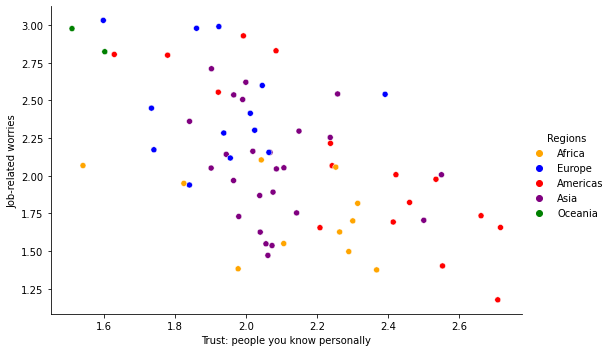

<Figure size 432x288 with 0 Axes>

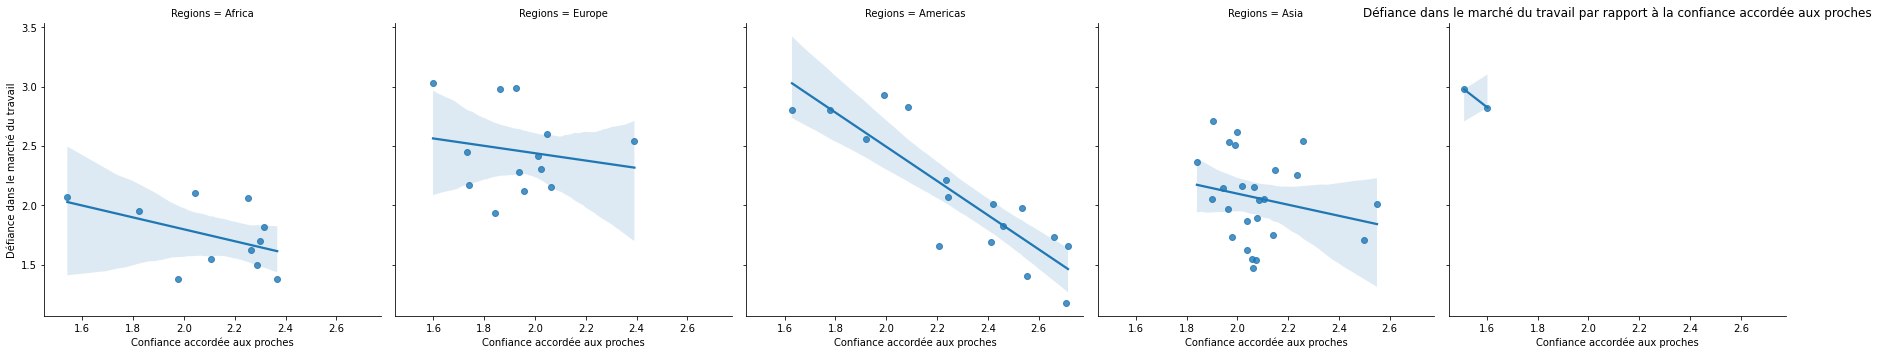

In [ ]:
sns.relplot(data=df_for_reg, x="Trust: people you know personally", y="Job-related worries",
            hue="Regions", aspect=1.5,palette=['orange','blue','red','purple','green'])    
    
print('Coefficients de corrélation')
for i in df_for_reg['Regions'].unique(): #pour chaque région géographique différente, on réalise la regression du sentidement de défiance par rapport à la confiance relationnelle 
    
    print('Continent {}: '.format(i),
          linregress(df_for_reg[df_for_reg['Regions']==i]['Trust: people you know personally'],
                     df_for_reg[df_for_reg['Regions']==i]['Job-related worries'])[2]**2)

#On affiche la figure et on détermine les axes 
fig = plt.figure()
g = sns.lmplot(data = df_for_reg,
               x = "Trust: people you know personally",
               y = "Job-related worries",
               col='Regions')

g.set_axis_labels('Confiance accordée aux proches', 'Défiance dans le marché du travail')
plt.title('Défiance dans le marché du travail par rapport à la confiance accordée aux proches')
plt.show()

Modèle très pertinent en Amérique, et dans une moindre mesure en Afrique: moins les habitants d'un pays sont méfiants envers leurs proches, moins on prédit qu'ils sont inquiets concernant l'emploi. Ceci témoigne là-encore d'un profil de confiance un peu manichéen.

# Régression linéaire du **SENTIMENT DE DÉFIANCE DANS LE MARCHÉ DU TRAVAIL** par rapport à la **CONFIANCE RELATIONNELLE**
#Répartition par **RÉGIME POLITIQUE**

Coefficients de corrélation
Régime politique Republic:  0.23305935855755713
Régime politique Constitutional monarchy:  0.5401463219337002
Régime politique Provisional:  0.4575774489172561


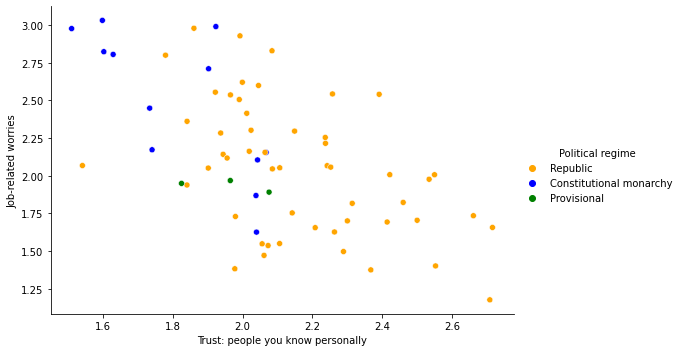

<Figure size 432x288 with 0 Axes>

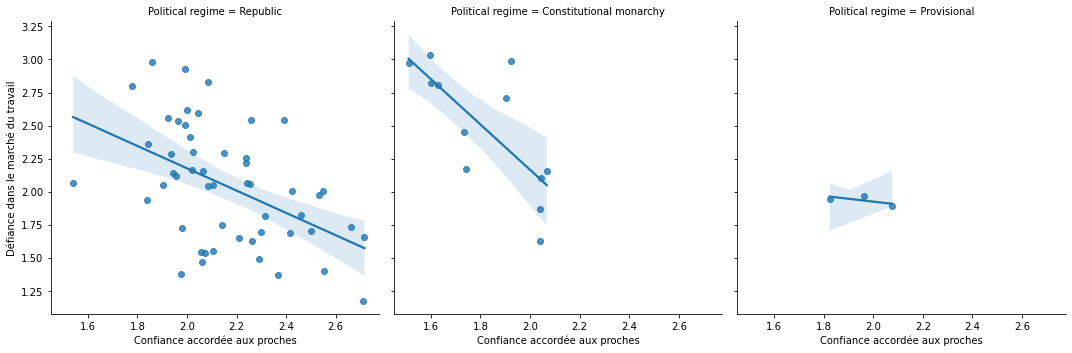

In [ ]:
sns.relplot(data=df_for_reg, x="Trust: people you know personally", y="Job-related worries",
            hue="Political regime", aspect=1.5,palette=['orange','blue','green'])    
    
print('Coefficients de corrélation')
for i in df_for_reg['Political regime'].unique():
    print('Régime politique {}: '.format(i),
          linregress(df_for_reg[df_for_reg['Political regime']==i]['Trust: people you know personally'],
                     df_for_reg[df_for_reg['Political regime']==i]['Job-related worries'])[2]**2)


fig = plt.figure()
g = sns.lmplot(data = df_for_reg,
               x = "Trust: people you know personally",
               y = "Job-related worries",
               col='Political regime')

g.set_axis_labels('Confiance accordée aux proches', 'Défiance dans le marché du travail')
plt.show()

Modèle plutôt pertinent dans les monarchies constitutionnelles, et dans une moindre mesure dans les républiques: moins les habitants d'un pays sont méfiants envers leurs proches, moins on prédit qu'ils sont inquiets concernant l'emploi. Ceci témoigne là-encore d'un profil de confiance un peu manichéen.

# *B. Régression linéaire de la confiance dans les banques*

#Regression linéaire de la **CONFIANCE DANS LES BANQUES** par rapport au **PIB PAR TÊTE**
#Répartition par **RÉGIME POLITIQUE**


Coefficient de corrélation pour le continent Republic:  0.16079291920096278
Coefficient de corrélation pour le continent Constitutional monarchy:  0.165018483617148
Coefficient de corrélation pour le continent Provisional:  0.1965682110874298


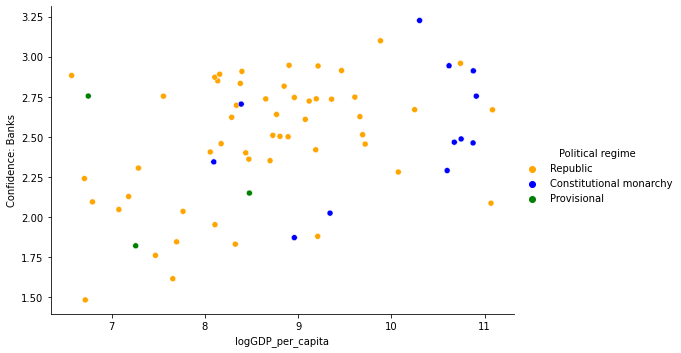

<Figure size 432x288 with 0 Axes>

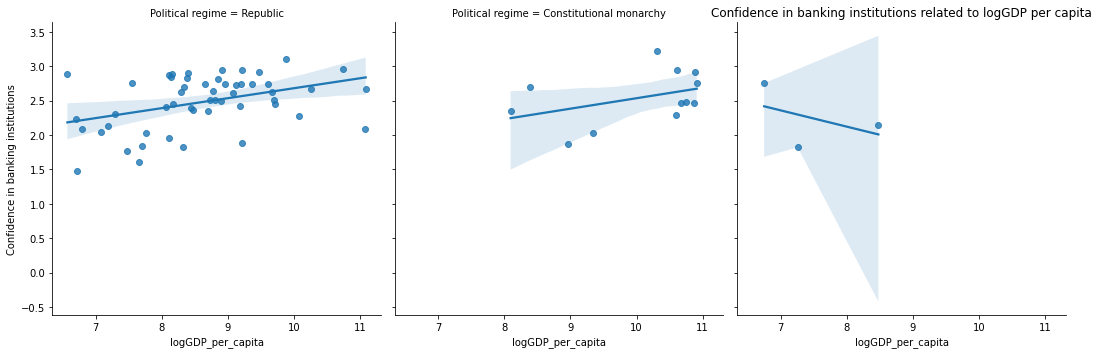

In [ ]:
sns.relplot(data=df_for_reg, x='logGDP_per_capita', y="Confidence: Banks",
            hue="Political regime", aspect=1.5,palette=['orange','blue','green'])    
    

for i in df_for_reg['Political regime'].unique():
    print('Coefficient de corrélation pour le continent {}: '.format(i),
          linregress(df_for_reg[df_for_reg['Political regime']==i]['logGDP_per_capita'],
                     df_for_reg[df_for_reg['Political regime']==i]['Confidence: Banks'])[2]**2)


fig = plt.figure()
g = sns.lmplot(data = df_for_reg,
               x = 'logGDP_per_capita',
               y = "Confidence: Banks",
               col='Political regime')

g.set_axis_labels('logGDP_per_capita', 'Confidence in banking institutions')
plt.title('Confidence in banking institutions related to logGDP per capita')
plt.show()

Modèle peu pertinent, indépendamment du régime politique.

# *C. Régression linéaire de la confiance dans les banques*

#Régression linéaire de la **CONFIANCE DANS LES BANQUES** par rapport à la **CONFIANCE DANS LES GRANDES ENTREPRISES**
#Répartition par **CONTINENT**

Coefficients de corrélation
Continent Africa:  0.555653110031737
Continent Europe:  0.7110953706715405
Continent Americas:  0.4485137647114119
Continent Asia:  0.6961396230642205
Continent Oceania:  1.0


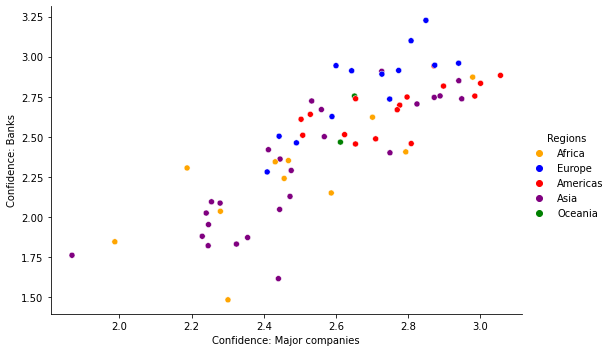

<Figure size 432x288 with 0 Axes>

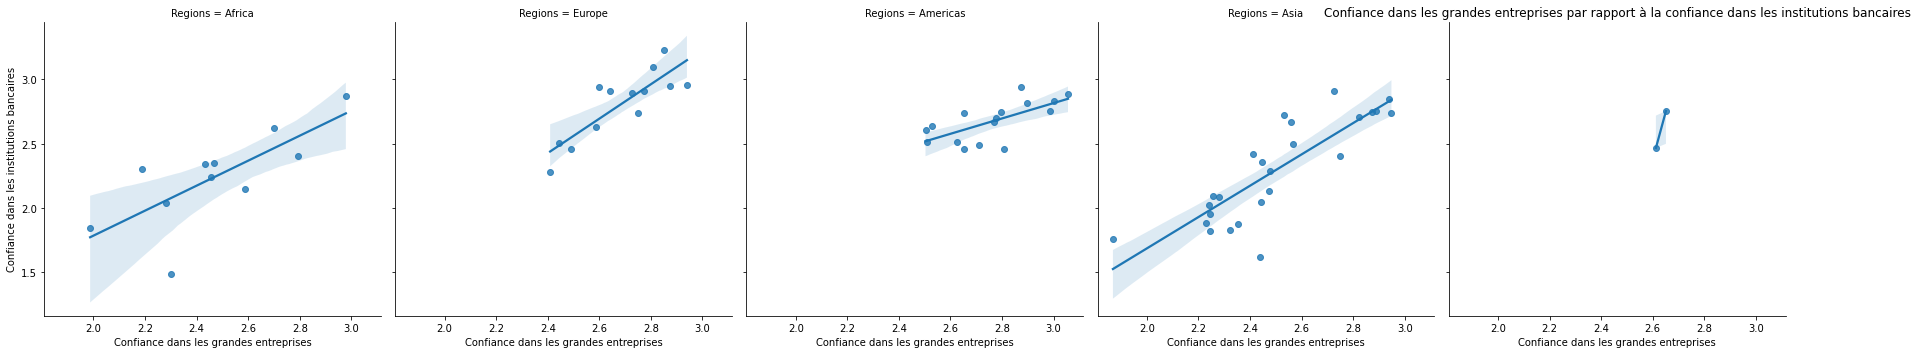

In [ ]:
sns.relplot(data=df_for_reg, x='Confidence: Major companies', y="Confidence: Banks",
            hue="Regions", aspect=1.5,palette=['orange','blue','red','purple','green'])    
    
print('Coefficients de corrélation')
for i in df_for_reg['Regions'].unique():
    print('Continent {}: '.format(i),
          linregress(df_for_reg[df_for_reg['Regions']==i]['Confidence: Major companies'],
                     df_for_reg[df_for_reg['Regions']==i]['Confidence: Banks'])[2]**2)


fig = plt.figure()
g = sns.lmplot(data = df_for_reg,
               x = 'Confidence: Major companies',
               y = "Confidence: Banks",
               col='Regions')

g.set_axis_labels('Confiance dans les grandes entreprises', 'Confiance dans les institutions bancaires')
plt.title('Confiance dans les grandes entreprises par rapport à la confiance dans les institutions bancaires')
plt.show()

Modèle très solide: la variable de confiance dans les grandes entreprises est un très bon indicateur de la confiance qu'accordent les gens aux banques, et ce dans tous les continents.

#Régression linéaire de la **CONFIANCE DANS LES BANQUES** par rapport à la **CONFIANCE DANS LES GRANDES ENTREPRISES**
#Répartition par **RÉGIME POLITIQUE**

Coefficients de corrélation
Régime politique Republic:  0.6842985585079662
Régime politique Constitutional monarchy:  0.6906208257806781
Régime politique Provisional:  0.9587282031714061


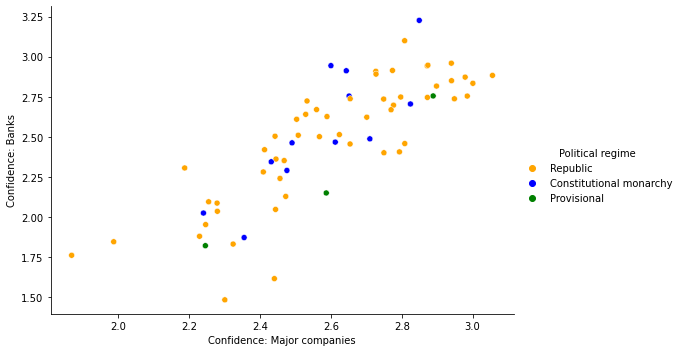

<Figure size 432x288 with 0 Axes>

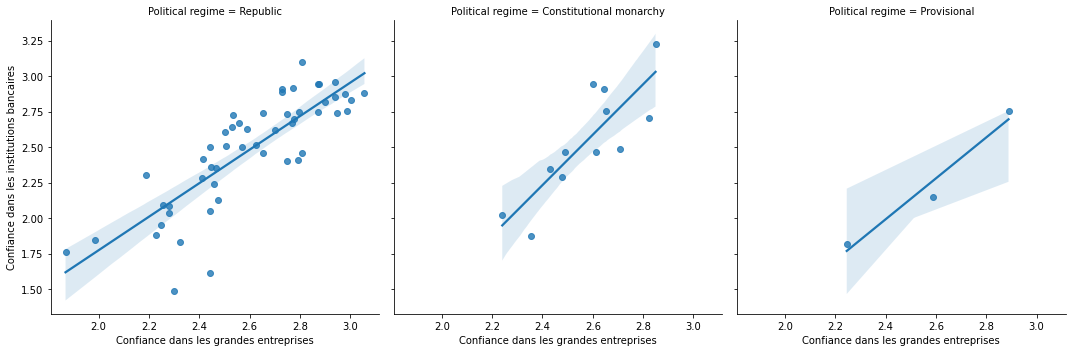

In [ ]:
sns.relplot(data=df_for_reg, x='Confidence: Major companies', y="Confidence: Banks",
            hue="Political regime", aspect=1.5,palette=['orange','blue','green'])    
    
print('Coefficients de corrélation')
for i in df_for_reg['Political regime'].unique():
    print('Régime politique {}: '.format(i),
          linregress(df_for_reg[df_for_reg['Political regime']==i]['Confidence: Major companies'],
                     df_for_reg[df_for_reg['Political regime']==i]['Confidence: Banks'])[2]**2)


fig = plt.figure()
g = sns.lmplot(data = df_for_reg,
               x = 'Confidence: Major companies',
               y = "Confidence: Banks",
               col='Political regime')

g.set_axis_labels('Confiance dans les grandes entreprises', 'Confiance dans les institutions bancaires')
#plt.title('Confiance dans les grandes entreprises par rapport à la confiance dans les institutions bancaires')
plt.show()

Modèle très solide: la variable de confiance dans les grandes entreprises est un très bon indicateur de la confiance qu'accordent les gens aux banques, et ce dans tous les régimes politiques.

## C*. Régression linéaire de la confiance dans le FMI*

#Régression linéaire de la **CONFIANCE DANS LE FMI** par rapport à la **CONFIANCE DANS LES GRANDES ENTREPRISES**
#Répartition par **CONTINENT**

Coefficients de corrélation
Continent Europe:  0.03536732984528158
Continent Americas:  0.09931892330921831
Continent Oceania:  1.0
Continent Asia:  0.7585927968496698
Continent Africa:  0.9312429156988752


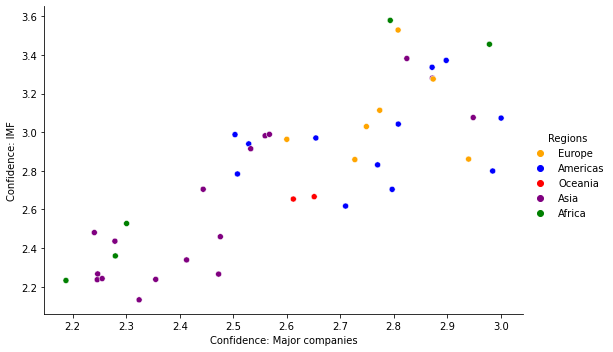

<Figure size 432x288 with 0 Axes>

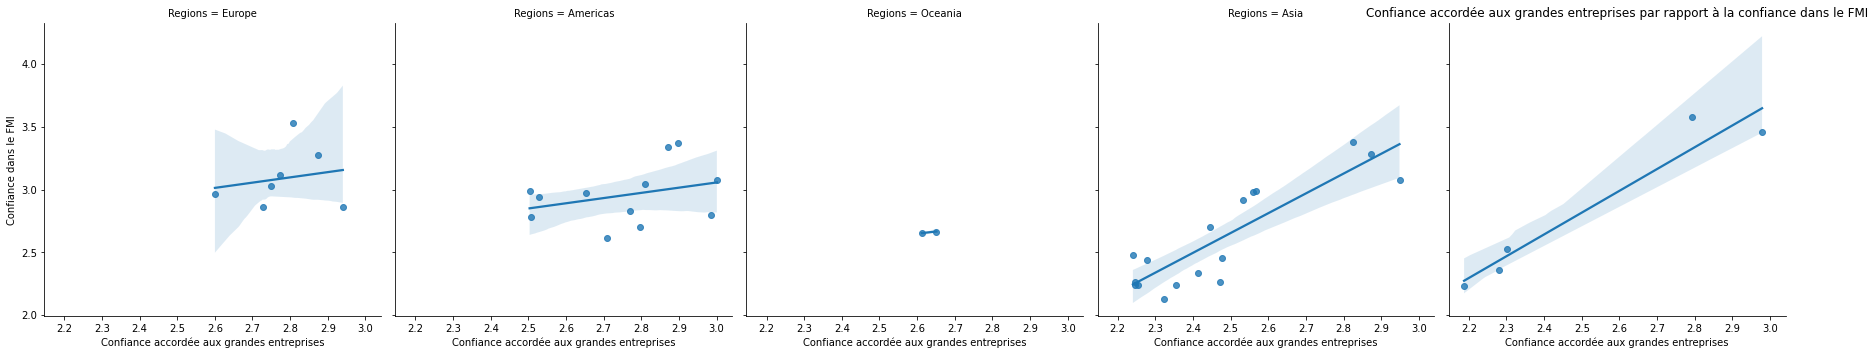

In [ ]:
sns.relplot(data=df_for_reg2, x='Confidence: Major companies', y="Confidence: IMF",
            hue="Regions", aspect=1.5,palette=['orange','blue','red','purple','green'])    
    
print('Coefficients de corrélation')
for i in df_for_reg2['Regions'].unique():
    print('Continent {}: '.format(i),
          linregress(df_for_reg2[df_for_reg2['Regions']==i]['Confidence: Major companies'],
                     df_for_reg2[df_for_reg2['Regions']==i]['Confidence: IMF'])[2]**2)


fig = plt.figure()
g = sns.lmplot(data = df_for_reg2,
               x = 'Confidence: Major companies',
               y = "Confidence: IMF",
               col='Regions')

g.set_axis_labels('Confiance accordée aux grandes entreprises', 'Confiance dans le FMI')
plt.title('Confiance accordée aux grandes entreprises par rapport à la confiance dans le FMI')
plt.show()

Modèle très solide en Asie et en Afrique (peut-être dû à un manque de données pour le continent africain): la variable de confiance dans les grandes entreprises est un très bon indicateur de la confiance qu'accordent les gens au FMI. Le modèle est moins bon en Europe (peut-être là aussi dû à un manque de données) et aussi en Amérique, ce qui est plus surprenant.

#Régression linéaire de la **CONFIANCE DANS LE FMI** par rapport à la **CONFIANCE DANS LES GRANDES ENTREPRISES**
#Répartition par **RÉGIME POLITIQUE**

Coefficients de corrélation
Régime politique Constitutional monarchy:  0.5803132846983462
Régime politique Republic:  0.6390257543431032
Régime politique Provisional:  0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


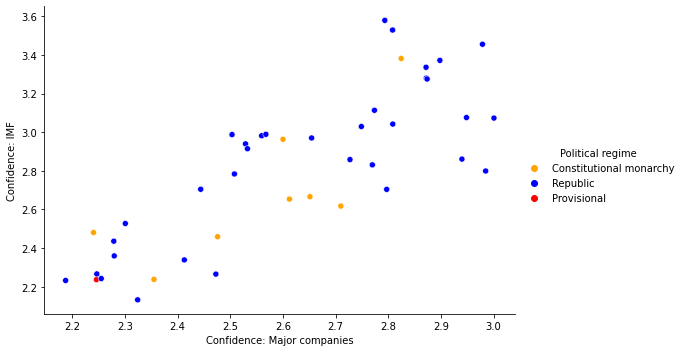

<Figure size 432x288 with 0 Axes>

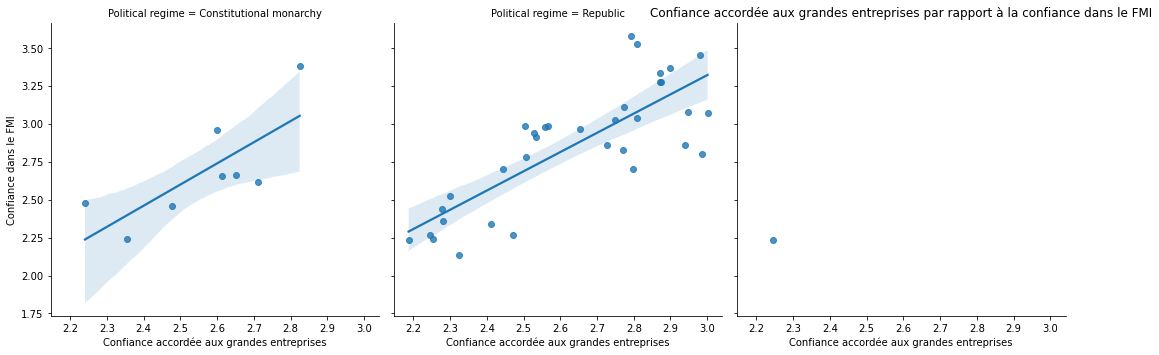

In [ ]:
sns.relplot(data=df_for_reg2, x='Confidence: Major companies', y="Confidence: IMF",
            hue="Political regime", aspect=1.5,palette=['orange','blue','red'])    
    
print('Coefficients de corrélation')
for i in df_for_reg2['Political regime'].unique():
    print('Régime politique {}: '.format(i),
          linregress(df_for_reg2[df_for_reg2['Political regime']==i]['Confidence: Major companies'],
                     df_for_reg2[df_for_reg2['Political regime']==i]['Confidence: IMF'])[2]**2)


fig = plt.figure()
g = sns.lmplot(data = df_for_reg2,
               x = 'Confidence: Major companies',
               y = "Confidence: IMF",
               col='Political regime')

g.set_axis_labels('Confiance accordée aux grandes entreprises', 'Confiance dans le FMI')
plt.title('Confiance accordée aux grandes entreprises par rapport à la confiance dans le FMI')
plt.show()

Modèle très solide indépendemment du régime politique: la variable de confiance dans les grandes entreprises est un très bon indicateur de la confiance qu'accordent les gens au FMI, et ce dans tous les régimes politiques.